# [0] Importing Libraries

In [1]:

from pathlib import Path
from torchinfo import summary
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import numpy as np

import torch
from torch import nn
from torchvision import models
from torchvision.transforms import v2 as transforms
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter

import spacy  # for tokenizer
from PIL import Image  # Load imgimport matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline
from tqdm.auto import tqdm
from colorama import Fore, Style
from helper_functions import *

# torch.backends.cudnn.benchmark = True
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# [1] Encoder CNN

In [2]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size: int):
        super().__init__()
        self.pt_weights = models.ResNet50_Weights.IMAGENET1K_V1
        self.pt_transforms = self.pt_weights.transforms
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)    
        for i in self.resnet.parameters():
            i.requires_grad = False
        
    def forward(self, imgs):
        return self.dropout(self.relu(self.resnet(imgs)))

# [2] Decoder RNN

In [3]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=False)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, features, captions):
        # TODO features rmbeddings
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0),embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        return self.linear(hiddens)

# [3] CNN to RNN

In [4]:
class CNNtoRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super().__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(vocab_size, embed_size, hidden_size, num_layers)
        
    def forward(self, imgs, captions):
        features = self.encoder(imgs)
        output = self.decoder(features, captions)
        return output
    
    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []
        with torch.no_grad():
            x = self.encoder(image).unsqueeze(0)
            states = None
            
            for _ in range(max_length):
                hiddens, states = self.decoder.lstm(x, states)
                output = self.decoder.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoder.embed(predicted).unsqueeze(0)
                
                if vocabulary.itos[predicted.item()] == '<EOS>':
                    break
                
        return [vocabulary.itos[idx] for idx in result_caption]

# [4] Vocabulary

In [5]:
spacy.prefer_gpu(gpu_id=0)
spacy_eng = spacy.load("en_core_web_sm")

class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

# [5] Flickr Dataset

In [6]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())
    
    def _get_vocab(self):
        return self.vocab

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

# [6] Dataloader

In [7]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets


def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)
    vocab = dataset._get_vocab()

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        persistent_workers=True,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
        pin_memory_device = device
    )

    return loader, dataset, vocab

In [8]:
imgs_path = Path("/home/23m1521/datasets/flickr8k/images")
captions_path = Path("/home/23m1521/datasets/flickr8k/captions.txt")

len(list(imgs_path.glob("*.jpg")))

8091

In [9]:
transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.RandomCrop((224, 224)),
    # transforms.ToTensor(),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# pt_transform = EncoderCNN(256).pt_transforms()
print(transform)

train_dataloader, dataset, vocab = get_loader(imgs_path, 
                                              captions_path, 
                                              transform=transform,
                                              batch_size=32,
                                              num_workers=os.cpu_count())

images, captions = next(iter(train_dataloader))
images.shape, captions.shape

Compose(
      Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomCrop(size=(224, 224), pad_if_needed=False, fill=0, padding_mode=constant)
      ToImage()
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)


(torch.Size([32, 3, 224, 224]), torch.Size([21, 32]))

In [10]:
for c in captions:
    # print(c)
    # captions[0].detach().cpu().tolist()
    print([vocab.itos[idx] for idx in c.detach().cpu().tolist()])

['<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>']
['men', 'three', 'a', 'little', 'two', 'overweight', 'two', 'a', 'a', 'a', 'two', 'a', 'a', 'a', 'girl', 'blurry', 'a', 'a', 'two', 'the', 'a', 'dog', 'a', 'a', 'a', 'a', 'a', 'adult', 'a', 'a', 'kids', 'two']
[',', 'men', 'young', 'boy', '<UNK>', 'man', 'dogs', 'black', 'brown', 'large', 'cyclists', 'group', 'boy', 'skateboarder', 'and', 'people', 'man', 'woman', 'men', 'couple', 'man', 'is', 'dog', 'child', 'black', 'boy', 'girl', 'man', 'man', 'young', 'play', 'kids']
['one', 'in', 'child', 'in', '<UNK>', 'with', 'are', 'labrador', 'and', ',', 'race', 'of', 'in', 'is', 'boy', 'walking', 'wearing', 'in', '<UNK>', 'takes', 'in', 'jumping', 'wearing', 'slides', 'dog', 'is', 'in', 'holds', 'wearing', 'b

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


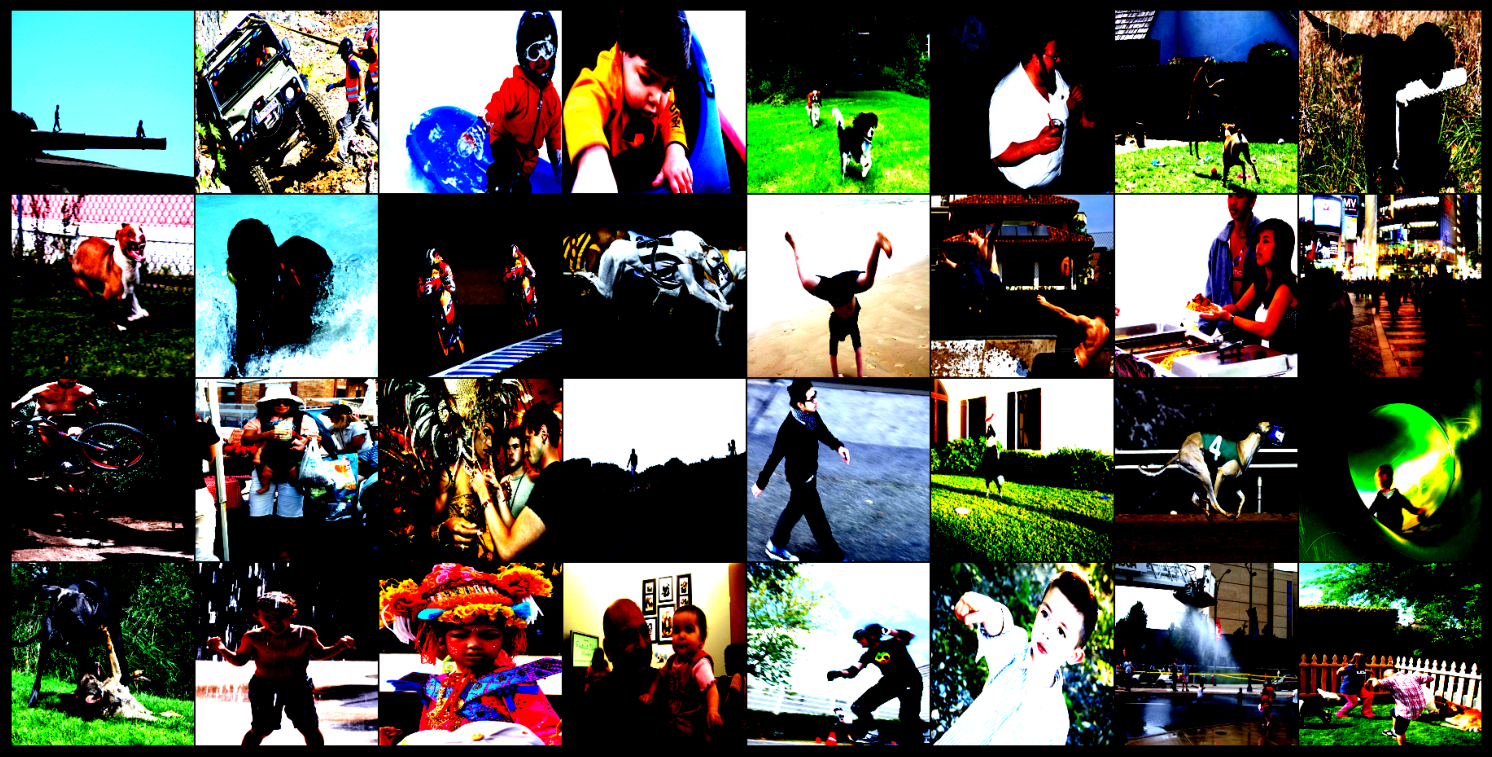

In [11]:
plt.figure(figsize=(19,10))
plt.imshow(make_grid(images).permute(1,2,0).detach().cpu().numpy())
plt.axis(False)
plt.show()

# [7] Training

In [12]:
'''train fun'''
def train_model(model: torch.nn.Module,
                train_dataloader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                lr_scheduler:torch.optim.lr_scheduler,
                device: torch.device,
                use_lr_sh:bool,
                load_model:bool,
                save_model:bool,
                epochs: int = 3,
                seed=None,
                plot=True):


    start_time = timer()
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
    
    # For Tensorboard
    writer = SummaryWriter("runs/flickr")
    step = 0
    
    if load_model:
        step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

    results = {"train_loss": []}
    
    for epoch in tqdm(range(epochs), desc="Train Epoch"):
        if save_model:
            checkpoint = {
                "state_dict" : model.state_dict(),
                "optimizer" : optimizer.state_dict(),
                "step" : step,
                "epoch": epoch
            }
            save_checkpoint(checkpoint)

        ### Training loop
        cum_train_loss = 0
        model.train()
        
        for batch, (X, y) in enumerate(tqdm(train_dataloader, desc="Train Batch", total=len(train_dataloader))):
        # for batch, (X, y) in enumerate(train_dataloader):
            # X, y = X.to(device), y.type(torch.LongTensor).to(device)
            X, y = X.to(device), y.to(device)
            
            y_logit = model(X, y[:-1]) # stoping model to learn end token
            
            # (seq_len, N, vocab_size), (seq_len, N)
            train_loss = loss_fn(y_logit.reshape(-1,y_logit.shape[2]), y.reshape(-1))
            writer.add_scalar("Training loss", train_loss.item(), global_step=step)
            step += 1
            optimizer.zero_grad()
            train_loss.backward()
            cum_train_loss += train_loss.item()
            optimizer.step()
            # xm.mark_step()

        cum_train_loss /= len(train_dataloader)
        
        if use_lr_sh:
            lr_scheduler.step()


        epoch_display = f" {epoch}" if epoch < 10 else epoch
        print(f"Epoch: {Fore.YELLOW}{epoch_display}{Style.RESET_ALL} | "
              f"Loss: ({Fore.YELLOW}{cum_train_loss:.4f}{Style.RESET_ALL}) | "        )


        results["train_loss"].append(cum_train_loss)


    end_time = timer()
    print(f"Train time on {device} is ", format_time(start_time, end_time))


    if plot:
        plt.figure(figsize=(19, 5))
        plt.plot(np.arange(1,epochs+1), results["train_loss"], label='Train Loss', color='green')
        plt.title('Loss')
        plt.legend()        
        plt.tight_layout()
        plt.show()
        
    return results



def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    # print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    # print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

'''optimizer'''
def get_optimizer(optimizer: str, model:torch.nn.Module, lr:float):
    if optimizer == 'adam':
        return torch.optim.Adam(params=model.parameters(),
                                lr=lr,
                                weight_decay=1e-5,
#                                 weight_decay=0.3,
                                amsgrad=False)

    elif optimizer == 'adamw':
        return torch.optim.AdamW(params=model.parameters(),
                                 lr=lr,
                                 weight_decay=1e-6)
#                                  weight_decay=0.3)

    elif optimizer == 'sgd':
        return torch.optim.SGD(params=model.parameters(),
                               lr=lr)


'''lr scheduler'''
def get_lr_scheduler(lr_sch: str, optimizer):
#     torch.optim.lr_scheduler.LinearLR
    if lr_sch == 'ReduceLROnPlateau':
        return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                          mode='min',
                                                          factor=0.2,
                                                          patience=4,
                                                          eps=1e-6)

    elif lr_sch == 'CosineAnnealingLR':
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                          T_max=15,
                                                          eta_min=1e-6,
                                                          last_epoch=-1)

    elif lr_sch == 'CosineAnnealingWarmRestarts':
        return torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                                    T_0=10,
                                                                    eta_min=1e-6,
                                                                    last_epoch=-1)

In [13]:
load_model = True
save_model = True

# Hyperparameters
embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 3e-4
num_epochs = 10

# Initialize model
model = CNNtoRNN(vocab_size, embed_size, hidden_size, num_layers).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"]).to(device)
optimizer = get_optimizer("adam", model, lr=learning_rate)
lr_scheduler = get_lr_scheduler("CosineAnnealingLR", optimizer)

In [14]:
images.shape, captions.shape

(torch.Size([32, 3, 224, 224]), torch.Size([21, 32]))

In [15]:
captions[-1]

tensor([0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
# 721/1000 

Train Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1265 [00:00<?, ?it/s]

Epoch:  0 | Loss: (2.4507) | 


Train Batch:   0%|          | 0/1265 [00:00<?, ?it/s]

Epoch:  1 | Loss: (2.4513) | 


Train Batch:   0%|          | 0/1265 [00:00<?, ?it/s]

Epoch:  2 | Loss: (2.4505) | 


Train Batch:   0%|          | 0/1265 [00:00<?, ?it/s]

Epoch:  3 | Loss: (2.4495) | 


Train Batch:   0%|          | 0/1265 [00:00<?, ?it/s]

Epoch:  4 | Loss: (2.4490) | 


Train Batch:   0%|          | 0/1265 [00:00<?, ?it/s]

Epoch:  5 | Loss: (2.4503) | 


Train Batch:   0%|          | 0/1265 [00:00<?, ?it/s]

Epoch:  6 | Loss: (2.4490) | 


Train Batch:   0%|          | 0/1265 [00:00<?, ?it/s]

Epoch:  7 | Loss: (2.4505) | 


Train Batch:   0%|          | 0/1265 [00:00<?, ?it/s]

Epoch:  8 | Loss: (2.4506) | 


Train Batch:   0%|          | 0/1265 [00:00<?, ?it/s]

Epoch:  9 | Loss: (2.4508) | 
Train time on cuda:0 is  7 minutes 1.81 seconds


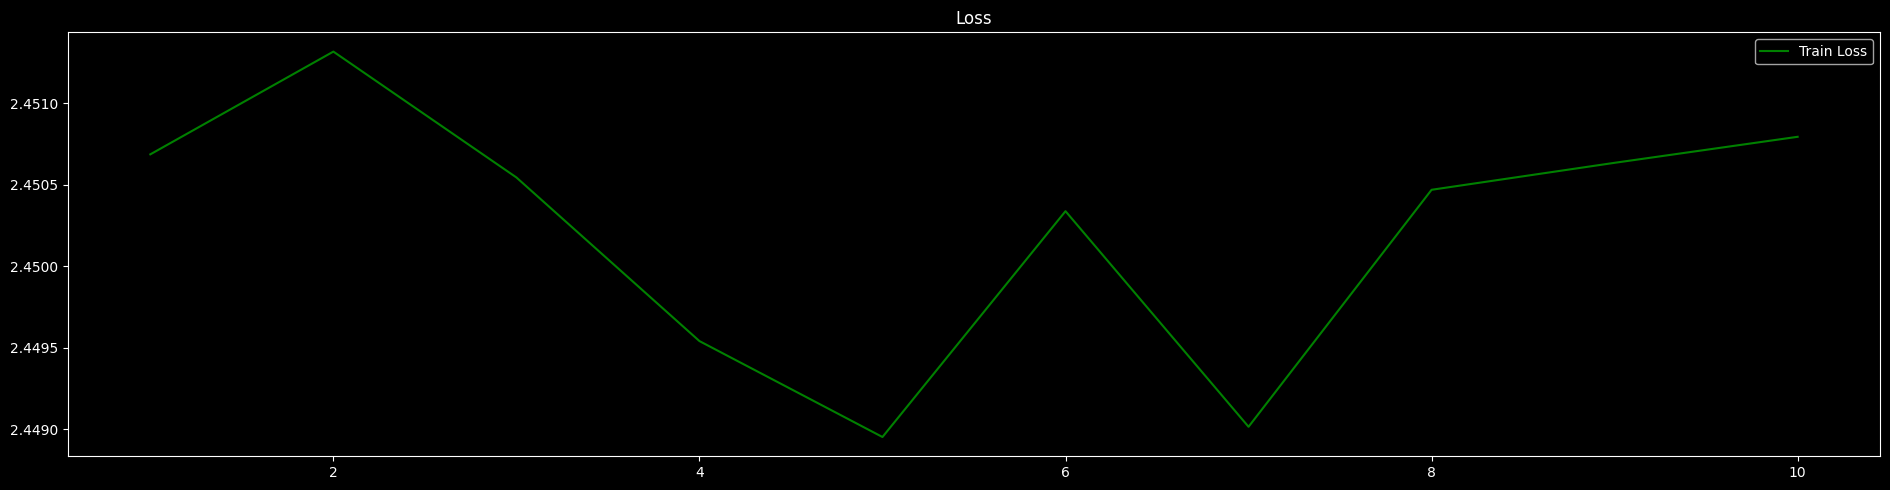

CPU times: user 6min 54s, sys: 54.4 s, total: 7min 48s
Wall time: 7min 1s


In [17]:
%%time
model_results = train_model(model=model,
                            train_dataloader=train_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            lr_scheduler=lr_scheduler,
                            device=device,
                            use_lr_sh=False,
                            load_model=load_model,
                            save_model=save_model,
                            epochs=num_epochs,
                            seed=42,
                            plot=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7582842..2.4308503].


Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog running through the grass . <EOS>


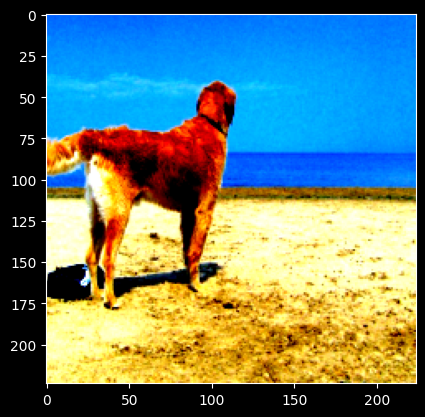

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little boy in a red shirt is jumping over a swing . <EOS>


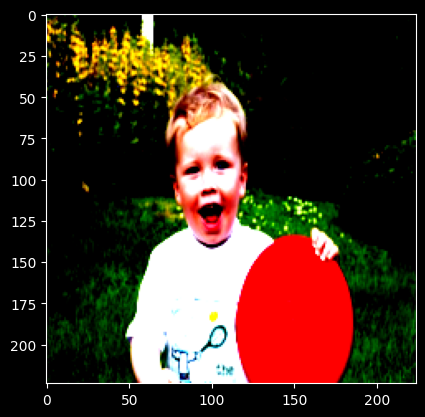

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.151983].


Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man is standing next to a woman on a bicycle . <EOS>


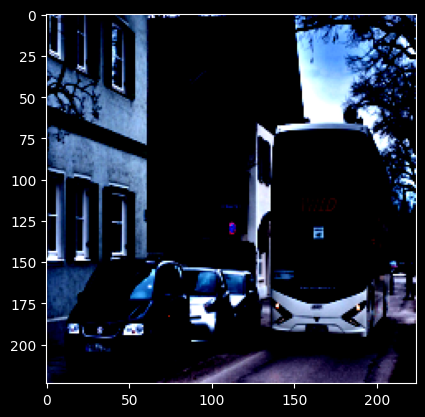

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.500567].


Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is standing on a beach . <EOS>


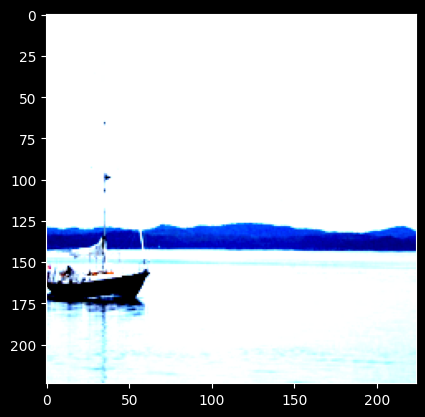

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.64].


Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a dog is running through a field of grass . <EOS>


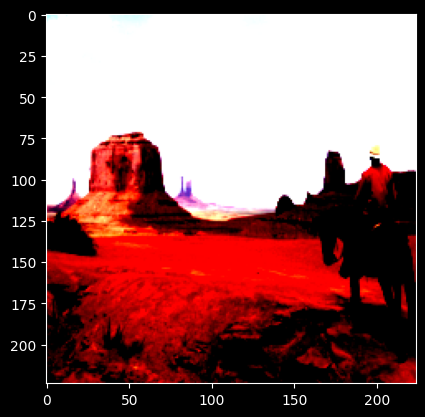

In [19]:
def print_examples(model, device, dataset):
    # transform = transforms.Compose(
    #     [
    #         transforms.Resize((299, 299)),
    #         transforms.ToTensor(),
    #         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    #     ]
    # )
    # load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)
    model.eval()
    
    img = Image.open("test_examples/dog.jpg").convert("RGB")
    test_img1 = transform(img).unsqueeze(0)
    print("Example 1 CORRECT: Dog on a beach by the ocean")
    print("Example 1 OUTPUT: " + " ".join(model.caption_image(test_img1.to(device), dataset.vocab)))
    # display(test_img1)
    plt.imshow(test_img1.squeeze(0).permute(1,2,0))
    plt.show()
    
    img = Image.open("test_examples/child.jpg").convert("RGB")
    test_img2 = transform(img).unsqueeze(0)
    print("Example 2 CORRECT: Child holding red frisbee outdoors")
    print("Example 2 OUTPUT: "+ " ".join(model.caption_image(test_img2.to(device), dataset.vocab)))
    # display(img)
    plt.imshow(test_img2.squeeze(0).permute(1,2,0))
    plt.show()
    
    img = Image.open("test_examples/bus.png").convert("RGB")
    test_img3 = transform(img).unsqueeze(0)
    print("Example 3 CORRECT: Bus driving by parked cars")
    print("Example 3 OUTPUT: "+ " ".join(model.caption_image(test_img3.to(device), dataset.vocab)))
    # display(img)
    plt.imshow(test_img3.squeeze(0).permute(1,2,0))
    plt.show()
    
    img = Image.open("test_examples/boat.png").convert("RGB")
    test_img4 = transform(img).unsqueeze(0)
    print("Example 4 CORRECT: A small boat in the ocean")
    print("Example 4 OUTPUT: "+ " ".join(model.caption_image(test_img4.to(device), dataset.vocab)))
    # display(img)
    plt.imshow(test_img4.squeeze(0).permute(1,2,0))
    plt.show()
    
    img = Image.open("test_examples/horse.png").convert("RGB")
    test_img5 = transform(img).unsqueeze(0)
    print("Example 5 CORRECT: A cowboy riding a horse in the desert")
    print("Example 5 OUTPUT: "+ " ".join(model.caption_image(test_img5.to(device), dataset.vocab)))
    # display(img)
    plt.imshow(test_img5.squeeze(0).permute(1,2,0))
    plt.show()
    
    model.train()
    
print_examples(model, device, dataset)